# 固定亂數確保每次執行結果相同

In [1]:
import torch 
import numpy as np 
import random 

def same_seeds(seed):
    random.seed(seed) 
    np.random.seed(seed)  
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) 
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
same_seeds(2526)

In [2]:
import os, cv2, numpy as np
from tqdm import tqdm

def load_images_and_labels(root='Image'):
    encode, decode = {}, {}
    x_train, y_train, x_valid, y_valid = [], [], [], []

    for idx, cls in enumerate(os.listdir(f'{root}/Train')):
        encode[cls] = idx
        decode[idx] = cls                  # 雙向對照表

    for split in ['Train', 'Valid']:
        for cls in os.listdir(f'{root}/{split}'):
            path = f'{root}/{split}/{cls}'
            for fname in tqdm(os.listdir(path), desc=f'Loading {split}/{cls}'):
                img = cv2.imread(f'{path}/{fname}').astype('float32') / 255
                if img is None:  # 避免讀檔失敗
                    continue
                img = np.transpose(img, (2, 0, 1))
                (x_train if split == 'Train' else x_valid).append(img)
                (y_train if split == 'Train' else y_valid).append(encode[cls])
    return x_train, y_train, x_valid, y_valid, encode, decode


x_train, y_train, x_valid, y_valid, label_encoding, label_decoding = load_images_and_labels('Image')

Loading Valid/Truck: 100%|██████████| 1000/1000 [00:00<00:00, 5709.02it/s]


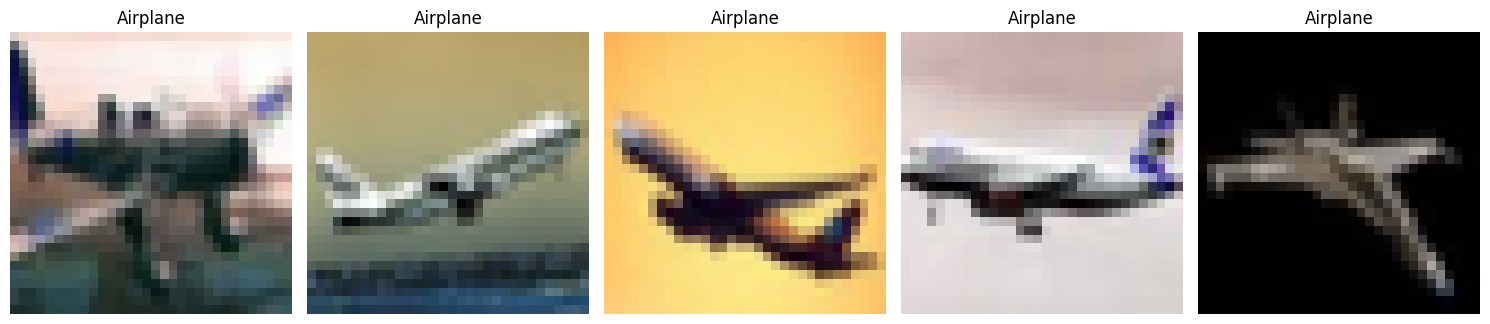

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def show_images(images, labels, label_decoding, num_images=5):
    plt.figure(figsize=(15, 5))
    for i in range(min(num_images, len(images))):  # 顯示指定數量的圖片
        img = images[i]
        # 轉回 HxWxC
        img = np.transpose(img, (1, 2, 0))
        img = (img * 255).astype('uint8')
        label = labels[i]
        class_name = label_decoding[label]
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


show_images(x_train, y_train, label_decoding, num_images=5)

# 亂數模擬資料

In [4]:
from torch.utils.data import Dataset, DataLoader

class CIFAR10(Dataset):
    def __init__(self, x, y, augment=False):  
        self.x = x
        self.y = y
        self.augment=augment 

    def __len__(self):         
        return len(self.x)
    
    def __getitem__(self, i):  
        return self.x[i], self.y[i]

    def collate_fn(self, batch):
        imgs, labels = [], []
        for img, lab in batch:
            img = torch.from_numpy(img)
            if self.augment and random.random() < 0.5:               # 50% 機率水平翻轉
                img = torch.flip(img, dims=[2])
            imgs.append(img)
            labels.append(lab)
        return {'x': torch.stack(imgs), 'y': torch.tensor(labels)}


trainset = CIFAR10(x_train, y_train, augment=True)
validset = CIFAR10(x_valid, y_valid)

train_loader = DataLoader(trainset, batch_size = 64, shuffle = True, num_workers = 0, pin_memory = True, collate_fn = trainset.collate_fn)
valid_loader = DataLoader(validset, batch_size = 64, shuffle = True, num_workers = 0, pin_memory = True, collate_fn = validset.collate_fn)

batch = next(iter(train_loader))
print('train batch shape:', batch['x'].shape)

train batch shape: torch.Size([64, 3, 32, 32])


In [ ]:
import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self, input_shape, num_layers, dropout2d_rate, linear_hidden, dropout_rate, num_classes):
        super(CNN, self).__init__()
        layers = []

        conv_channels = []
        base_channel = 64
        for i in range(num_layers):
            out_channels = min(base_channel * (2 ** i), 512)
            conv_channels.append(out_channels)

        in_channels = input_shape[0]
        for out_channels in conv_channels:
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout2d(dropout2d_rate))
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            in_channels = out_channels

        self.feature_extractor = nn.Sequential(*layers)

        dummy_input = torch.zeros(1, *input_shape)
        # 用假的資料得到正確形狀
        with torch.no_grad():
            dummy_output = self.feature_extractor(dummy_input)
        final_feature_size = dummy_output.view(1, -1).size(1)

        self.classifier = nn.Sequential(
            nn.Linear(final_feature_size, linear_hidden),
            nn.BatchNorm1d(linear_hidden),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(linear_hidden, num_classes)
        )

        self.criterion = nn.CrossEntropyLoss()

    def forward(self, **kwargs):
        x = kwargs['x']
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        loss = self.criterion(x, kwargs['y'])
        return loss, x
    @torch.no_grad()
    def predict(self, **kwargs):
        self.eval()
        x = kwargs['x']
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        preds = torch.argmax(x, dim=1)
        return preds.cpu().numpy()


input_shape = (3, 32, 32)
model = CNN(
    input_shape=input_shape,
    num_layers=3,
    dropout2d_rate=0.3,
    linear_hidden=512,
    dropout_rate=0.5,
    num_classes=10
)
print(model)

CNN(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.3, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Dropout2d(p=0.3, inplace=False)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): Dropout2d(p=0.3, inplace=False)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    

Using device: cuda


Valid Epoch 0: 100%|██████████| 157/157 [00:00<00:00, 305.92it/s, loss=1.125]


Saving Model With Loss 1.17993
Train Loss: 1.58919| Valid Loss: 1.17993| Best Loss: 1.17993



Valid Epoch 1: 100%|██████████| 157/157 [00:00<00:00, 324.71it/s, loss=0.617]


Saving Model With Loss 1.01600
Train Loss: 1.25890| Valid Loss: 1.01600| Best Loss: 1.01600



Valid Epoch 2: 100%|██████████| 157/157 [00:00<00:00, 255.47it/s, loss=0.563]


Saving Model With Loss 0.91809
Train Loss: 1.13375| Valid Loss: 0.91809| Best Loss: 0.91809



Valid Epoch 3: 100%|██████████| 157/157 [00:00<00:00, 269.83it/s, loss=0.670]


Saving Model With Loss 0.84780
Train Loss: 1.05305| Valid Loss: 0.84780| Best Loss: 0.84780



Valid Epoch 4: 100%|██████████| 157/157 [00:00<00:00, 239.61it/s, loss=0.339]


Saving Model With Loss 0.81029
Train Loss: 0.99041| Valid Loss: 0.81029| Best Loss: 0.81029



Valid Epoch 5: 100%|██████████| 157/157 [00:00<00:00, 275.56it/s, loss=0.984]


Saving Model With Loss 0.77019
Train Loss: 0.94310| Valid Loss: 0.77019| Best Loss: 0.77019



Valid Epoch 6: 100%|██████████| 157/157 [00:00<00:00, 249.44it/s, loss=0.806]


Saving Model With Loss 0.73460
Train Loss: 0.91100| Valid Loss: 0.73460| Best Loss: 0.73460



Valid Epoch 7: 100%|██████████| 157/157 [00:00<00:00, 287.18it/s, loss=1.079]


Saving Model With Loss 0.72201
Train Loss: 0.87381| Valid Loss: 0.72201| Best Loss: 0.72201



Valid Epoch 8: 100%|██████████| 157/157 [00:00<00:00, 282.42it/s, loss=0.769]


Saving Model With Loss 0.69636
Train Loss: 0.84830| Valid Loss: 0.69636| Best Loss: 0.69636



Valid Epoch 9: 100%|██████████| 157/157 [00:00<00:00, 280.63it/s, loss=0.363]


Saving Model With Loss 0.68263
Train Loss: 0.82063| Valid Loss: 0.68263| Best Loss: 0.68263



Valid Epoch 10: 100%|██████████| 157/157 [00:00<00:00, 287.84it/s, loss=0.553]


Saving Model With Loss 0.65534
Train Loss: 0.80175| Valid Loss: 0.65534| Best Loss: 0.65534



Valid Epoch 11: 100%|██████████| 157/157 [00:00<00:00, 268.23it/s, loss=0.506]


Saving Model With Loss 0.64899
Train Loss: 0.76796| Valid Loss: 0.64899| Best Loss: 0.64899



Valid Epoch 12: 100%|██████████| 157/157 [00:00<00:00, 288.40it/s, loss=0.363]


Saving Model With Loss 0.64603
Train Loss: 0.75660| Valid Loss: 0.64603| Best Loss: 0.64603



Valid Epoch 13: 100%|██████████| 157/157 [00:00<00:00, 282.70it/s, loss=0.531]


Saving Model With Loss 0.63064
Train Loss: 0.73739| Valid Loss: 0.63064| Best Loss: 0.63064



Valid Epoch 14: 100%|██████████| 157/157 [00:00<00:00, 284.56it/s, loss=0.478]


Saving Model With Loss 0.60286
Train Loss: 0.72151| Valid Loss: 0.60286| Best Loss: 0.60286



Valid Epoch 15: 100%|██████████| 157/157 [00:00<00:00, 259.61it/s, loss=0.394]


Train Loss: 0.71129| Valid Loss: 0.60757| Best Loss: 0.60286



Valid Epoch 16: 100%|██████████| 157/157 [00:00<00:00, 283.49it/s, loss=0.600]


Saving Model With Loss 0.58603
Train Loss: 0.69017| Valid Loss: 0.58603| Best Loss: 0.58603



Valid Epoch 17: 100%|██████████| 157/157 [00:00<00:00, 261.08it/s, loss=0.712]


Train Loss: 0.67999| Valid Loss: 0.58699| Best Loss: 0.58603



Valid Epoch 18: 100%|██████████| 157/157 [00:00<00:00, 290.87it/s, loss=0.552]


Saving Model With Loss 0.58137
Train Loss: 0.66488| Valid Loss: 0.58137| Best Loss: 0.58137



Valid Epoch 19: 100%|██████████| 157/157 [00:00<00:00, 250.69it/s, loss=0.334]


Saving Model With Loss 0.56058
Train Loss: 0.65344| Valid Loss: 0.56058| Best Loss: 0.56058



Valid Epoch 20: 100%|██████████| 157/157 [00:00<00:00, 276.15it/s, loss=0.463]


Train Loss: 0.63880| Valid Loss: 0.57061| Best Loss: 0.56058



Valid Epoch 21: 100%|██████████| 157/157 [00:00<00:00, 260.15it/s, loss=0.427]


Saving Model With Loss 0.55847
Train Loss: 0.62860| Valid Loss: 0.55847| Best Loss: 0.55847



Valid Epoch 22: 100%|██████████| 157/157 [00:00<00:00, 266.85it/s, loss=0.608]


Saving Model With Loss 0.55071
Train Loss: 0.62168| Valid Loss: 0.55071| Best Loss: 0.55071



Valid Epoch 23: 100%|██████████| 157/157 [00:00<00:00, 304.77it/s, loss=0.191]


Saving Model With Loss 0.54092
Train Loss: 0.61193| Valid Loss: 0.54092| Best Loss: 0.54092



Valid Epoch 24: 100%|██████████| 157/157 [00:00<00:00, 292.26it/s, loss=0.539]


Saving Model With Loss 0.53970
Train Loss: 0.60228| Valid Loss: 0.53970| Best Loss: 0.53970



Valid Epoch 25: 100%|██████████| 157/157 [00:00<00:00, 298.89it/s, loss=0.486]


Train Loss: 0.59307| Valid Loss: 0.54149| Best Loss: 0.53970



Valid Epoch 26: 100%|██████████| 157/157 [00:00<00:00, 257.45it/s, loss=0.695]


Saving Model With Loss 0.53428
Train Loss: 0.58087| Valid Loss: 0.53428| Best Loss: 0.53428



Valid Epoch 27: 100%|██████████| 157/157 [00:00<00:00, 299.86it/s, loss=0.896]


Saving Model With Loss 0.52689
Train Loss: 0.57443| Valid Loss: 0.52689| Best Loss: 0.52689



Valid Epoch 28: 100%|██████████| 157/157 [00:00<00:00, 279.77it/s, loss=0.475]


Saving Model With Loss 0.52563
Train Loss: 0.56653| Valid Loss: 0.52563| Best Loss: 0.52563



Valid Epoch 29: 100%|██████████| 157/157 [00:00<00:00, 269.14it/s, loss=0.557]


Saving Model With Loss 0.51504
Train Loss: 0.55338| Valid Loss: 0.51504| Best Loss: 0.51504



Valid Epoch 30: 100%|██████████| 157/157 [00:00<00:00, 265.96it/s, loss=0.791]


Train Loss: 0.54794| Valid Loss: 0.51613| Best Loss: 0.51504



Valid Epoch 31: 100%|██████████| 157/157 [00:00<00:00, 274.80it/s, loss=0.530]


Saving Model With Loss 0.50905
Train Loss: 0.54051| Valid Loss: 0.50905| Best Loss: 0.50905



Valid Epoch 32: 100%|██████████| 157/157 [00:00<00:00, 273.07it/s, loss=0.648]


Train Loss: 0.53203| Valid Loss: 0.51745| Best Loss: 0.50905



Valid Epoch 33: 100%|██████████| 157/157 [00:00<00:00, 293.84it/s, loss=0.413]


Saving Model With Loss 0.50634
Train Loss: 0.53206| Valid Loss: 0.50634| Best Loss: 0.50634



Valid Epoch 34: 100%|██████████| 157/157 [00:00<00:00, 301.18it/s, loss=0.642]


Saving Model With Loss 0.50028
Train Loss: 0.51966| Valid Loss: 0.50028| Best Loss: 0.50028



Valid Epoch 35: 100%|██████████| 157/157 [00:00<00:00, 271.39it/s, loss=0.370]


Saving Model With Loss 0.49734
Train Loss: 0.51187| Valid Loss: 0.49734| Best Loss: 0.49734



Valid Epoch 36: 100%|██████████| 157/157 [00:00<00:00, 308.71it/s, loss=0.213]


Train Loss: 0.50860| Valid Loss: 0.50350| Best Loss: 0.49734



Valid Epoch 37: 100%|██████████| 157/157 [00:00<00:00, 320.84it/s, loss=0.191]


Saving Model With Loss 0.49419
Train Loss: 0.49658| Valid Loss: 0.49419| Best Loss: 0.49419



Valid Epoch 38: 100%|██████████| 157/157 [00:00<00:00, 311.97it/s, loss=0.331]


Saving Model With Loss 0.49147
Train Loss: 0.49551| Valid Loss: 0.49147| Best Loss: 0.49147



Valid Epoch 39: 100%|██████████| 157/157 [00:00<00:00, 306.97it/s, loss=0.471]


Saving Model With Loss 0.48905
Train Loss: 0.48362| Valid Loss: 0.48905| Best Loss: 0.48905



Valid Epoch 40: 100%|██████████| 157/157 [00:00<00:00, 292.58it/s, loss=0.355]


Saving Model With Loss 0.48819
Train Loss: 0.48856| Valid Loss: 0.48819| Best Loss: 0.48819



Valid Epoch 41: 100%|██████████| 157/157 [00:00<00:00, 260.46it/s, loss=0.452]


Saving Model With Loss 0.48465
Train Loss: 0.47570| Valid Loss: 0.48465| Best Loss: 0.48465



Valid Epoch 42: 100%|██████████| 157/157 [00:00<00:00, 287.49it/s, loss=0.388]


Train Loss: 0.47380| Valid Loss: 0.49106| Best Loss: 0.48465



Valid Epoch 43: 100%|██████████| 157/157 [00:00<00:00, 274.32it/s, loss=0.479]


Train Loss: 0.46315| Valid Loss: 0.48958| Best Loss: 0.48465



Valid Epoch 44: 100%|██████████| 157/157 [00:00<00:00, 270.53it/s, loss=0.782]


Train Loss: 0.46434| Valid Loss: 0.48848| Best Loss: 0.48465



Valid Epoch 45: 100%|██████████| 157/157 [00:00<00:00, 294.79it/s, loss=0.599]


Saving Model With Loss 0.48152
Train Loss: 0.46002| Valid Loss: 0.48152| Best Loss: 0.48152



Valid Epoch 46: 100%|██████████| 157/157 [00:00<00:00, 303.79it/s, loss=0.404]


Saving Model With Loss 0.47360
Train Loss: 0.44863| Valid Loss: 0.47360| Best Loss: 0.47360



Valid Epoch 47: 100%|██████████| 157/157 [00:00<00:00, 293.15it/s, loss=0.217]


Saving Model With Loss 0.46988
Train Loss: 0.44602| Valid Loss: 0.46988| Best Loss: 0.46988



Valid Epoch 48: 100%|██████████| 157/157 [00:00<00:00, 291.73it/s, loss=0.317]


Train Loss: 0.44503| Valid Loss: 0.47636| Best Loss: 0.46988



Valid Epoch 49: 100%|██████████| 157/157 [00:00<00:00, 283.24it/s, loss=0.632]


Train Loss: 0.44049| Valid Loss: 0.47473| Best Loss: 0.46988



Valid Epoch 50: 100%|██████████| 157/157 [00:00<00:00, 281.67it/s, loss=0.420]


Train Loss: 0.43555| Valid Loss: 0.47136| Best Loss: 0.46988



Valid Epoch 51: 100%|██████████| 157/157 [00:00<00:00, 280.65it/s, loss=1.217]


Train Loss: 0.42604| Valid Loss: 0.48457| Best Loss: 0.46988



Valid Epoch 52: 100%|██████████| 157/157 [00:00<00:00, 302.25it/s, loss=0.651]


Train Loss: 0.42624| Valid Loss: 0.47896| Best Loss: 0.46988

------------------------------------
|Model can't improve, stop training|
------------------------------------


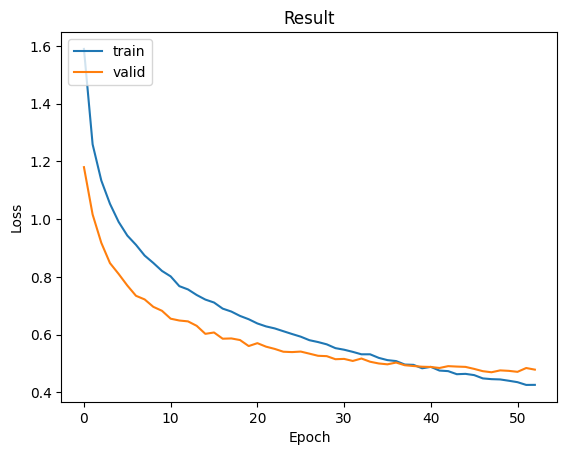

Best model loaded from ./checkpoints\best_model.ckpt


In [6]:
from Trainer import Trainer
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr = 2e-4)

trainer = Trainer(
    epochs=100,
    train_loader=train_loader,
    valid_loader=valid_loader,
    model=model,
    optimizer=optimizer,
    early_stopping=5,
    load_best_model=True,
    grad_clip = 1.0
)

trainer.train(show_loss=True)

Eval: 100%|██████████| 157/157 [00:00<00:00, 189.63it/s]


              precision    recall  f1-score   support

    Airplane     0.8638    0.8500    0.8569      1000
        Bird     0.7992    0.7560    0.7770      1000
         Car     0.9193    0.9340    0.9266      1000
         Cat     0.7001    0.6840    0.6920      1000
        Deer     0.8035    0.8630    0.8322      1000
         Dog     0.7602    0.7480    0.7540      1000
        Frog     0.8629    0.9000    0.8811      1000
       Horse     0.8896    0.8620    0.8756      1000
        Ship     0.9028    0.9190    0.9108      1000
       Truck     0.8938    0.8840    0.8889      1000

    accuracy                         0.8400     10000
   macro avg     0.8395    0.8400    0.8395     10000
weighted avg     0.8395    0.8400    0.8395     10000



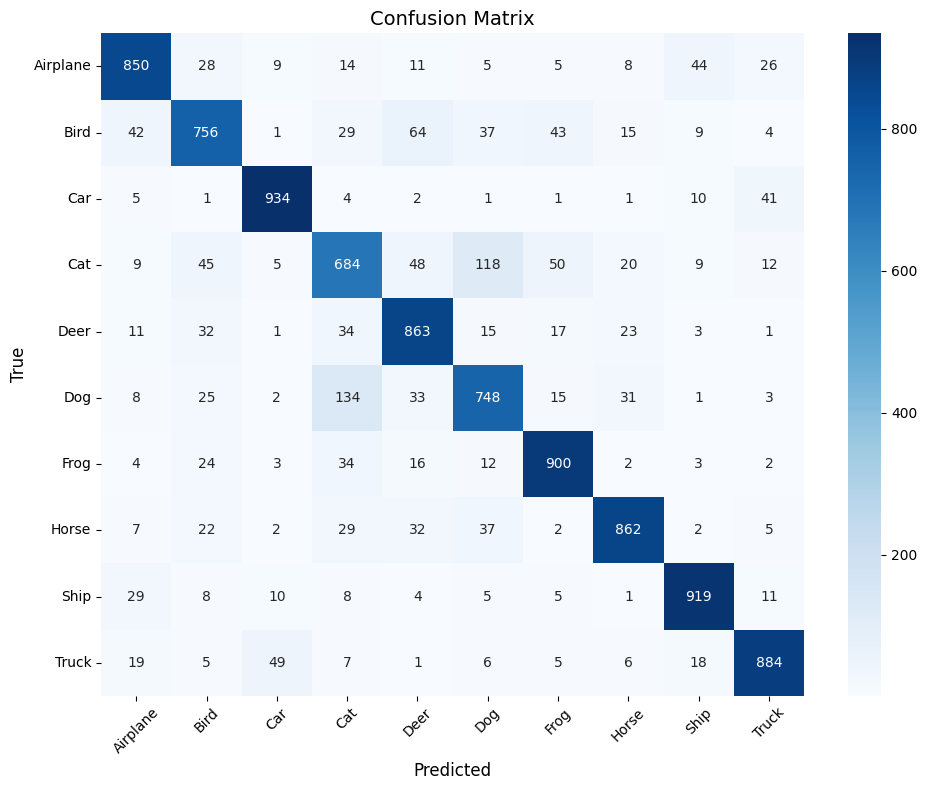

In [11]:
import torch
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_and_report(model, data_loader, label_decoding, device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    all_preds = []
    all_labels = []
    eval_pbar = tqdm(data_loader, position=0, leave=True)

    for input_datas in eval_pbar:
        input_datas = {k: v.to(device) for k, v in input_datas.items()}
        preds = model.predict(**input_datas)
        labels = input_datas['y']
        all_preds.extend(preds.tolist())
        all_labels.extend(labels.tolist())
        eval_pbar.set_description(f'Eval')

    decoded_labels = [label_decoding[l] for l in all_labels]
    decoded_preds = [label_decoding[p] for p in all_preds]

    print(classification_report(decoded_labels, decoded_preds, digits=4, zero_division=0))

    cm = confusion_matrix(decoded_labels, decoded_preds, labels=list(label_decoding.values()))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=list(label_decoding.values()),
                yticklabels=list(label_decoding.values()))
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('True', fontsize=12)
    plt.title('Confusion Matrix', fontsize=14)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

evaluate_and_report(model, valid_loader, label_decoding)


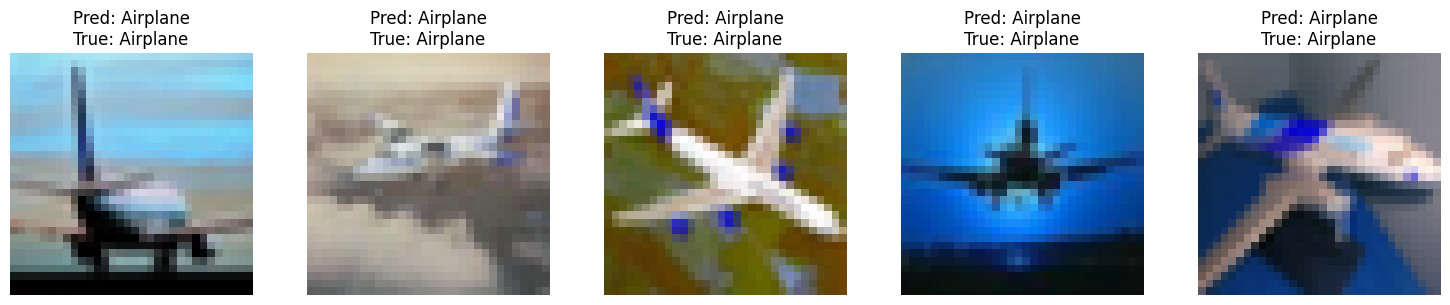

In [18]:
def show_sample_predictions(model, x_valid, y_valid, label_decoding, num_samples=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    with torch.no_grad():
        # x_valid assumed to be (N, C, H, W) and in 0~1
        x_valid_array = np.array(x_valid)
        x_tensor = torch.from_numpy(x_valid_array).float().to(device)
        
        # 預測 logits，取最大 index
        y_pred = model.predict(x = x_tensor)

    num_samples = min(num_samples, len(x_valid))
    plt.figure(figsize=(3 * num_samples, 3))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        img = x_valid[i]  # shape: (C, H, W)
        img = np.transpose(img, (1, 2, 0))  # -> (H, W, C)
        img = (img * 255).astype('uint8')  # 還原像素值
        plt.imshow(img)
        plt.title(f"Pred: {label_decoding[y_pred[i]]}\nTrue: {label_decoding[y_valid[i]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    
show_sample_predictions(model, x_valid, y_valid, label_decoding=label_decoding, num_samples=5)